# Imports


In [1]:
# Python: 3.13.2 (v3.13.2:4f8bb3947cf, Feb  4 2025, 11:51:10) [Clang 15.0.0 (clang-1500.3.9.4)]

import importlib
import subprocess

def install_package(package, version):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}=={version}...")
        subprocess.check_call(["pip", "install", f"{package}=={version}"])

packages = [
    {"package": "pandas", "version": "2.2.3"},
    {"package": "numpy", "version": "2.2.3"},
    {"package": "matplotlib", "version": "3.10.1"},
    {"package": "seaborn", "version": "0.13.2"},
    {"package": "scipy", "version": "1.15.2"},
    {"package": "scikit-learn", "version": "1.6.1"},
    {"package": "lightgbm", "version": "4.6.0"},
    {"package": "xgboost", "version": "2.1.4"},
]

for pkg in packages:
    install_package(pkg["package"], pkg["version"])

pandas is already installed.
numpy is already installed.
matplotlib is already installed.
seaborn is already installed.
scipy is already installed.
Installing scikit-learn==1.6.1...
lightgbm is already installed.
xgboost is already installed.


In [2]:
# Standard library imports
import os  # Provides functions for interacting with the operating system
import re  # Enables regular expression operations
import time  # Provides time-related functions
from collections import Counter  # Implements a counter for counting hashable objects
from pathlib import Path  # Offers a way to interact with files and directories

# Third-party imports
import matplotlib.pyplot as plt  # Collection of functions that make matplotlib work like MATLAB
import numpy as np  # Supports large, multi-dimensional arrays and matrices, along with math functions
import pandas as pd  # Offers data structures and data analysis tools
import seaborn as sns  # Provides a high-level interface for drawing attractive and informative statistical graphics
from scipy.stats import norm, ttest_rel, wilcoxon  # Includes statistical functions, e.g., distributions, tests

# Scikit-learn imports
from sklearn.calibration import label_binarize  # Utility to binarize labels in a one-vs-all fashion
from sklearn.compose import ColumnTransformer  # Applies transformers to columns of an array or pandas DataFrame
from sklearn.dummy import DummyClassifier  # Serves as a simple baseline classifier
from sklearn.ensemble import (  # Includes various ensemble methods
    AdaBoostClassifier,  # AdaBoost classifier
    BaggingClassifier,  # Bagging classifier
    GradientBoostingClassifier,  # Gradient Boosting classifier
    RandomForestClassifier,  # Random Forest classifier
)
from sklearn.metrics import (  # Includes metrics for evaluating model performance
    ConfusionMatrixDisplay,  # Visualizes confusion matrix
    auc,  # Computes Area Under the Curve (AUC)
    confusion_matrix,  # Computes confusion matrix
    f1_score,  # Computes the F1 score
    recall_score,  # Computes recall
    roc_auc_score,  # Computes Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    roc_curve,  # Computes the ROC curve
)
from sklearn.model_selection import (  # Includes tools for model selection
    GridSearchCV,  # Implements exhaustive grid search over specified parameter values for an estimator
    RepeatedStratifiedKFold,  # Provides repeated stratified K-fold cross-validator
    StratifiedKFold,  # Provides stratified K-fold cross-validator
)
from sklearn.naive_bayes import GaussianNB  # Implements Gaussian Naive Bayes algorithm
from sklearn.neighbors import KNeighborsClassifier  # Implements k-Nearest Neighbors algorithm
from sklearn.pipeline import Pipeline  # Chains transformers and estimators
from sklearn.preprocessing import StandardScaler  # Standardizes features by removing the mean and scaling to unit variance
from sklearn.tree import DecisionTreeClassifier  # Implements Decision Tree classifier

# LightGBM and XGBoost imports
from lightgbm import LGBMClassifier  # Implements Light Gradient Boosting Machine classifier
from xgboost import XGBClassifier  # Implements XGBoost classifier

# Setup


In [3]:
# =============================================================================
# 1. SETUP: PATHS & OUTPUT FOLDERS
# =============================================================================
INPUT_FOLDER = Path("../data")
OUTPUT_FOLDER = Path("../results")

TABLES_FOLDER    = "tables"
BOXPLOTS_FOLDER  = "boxplots"
ROC_CURVE_FOLDER = "roc_curve"
CONF_MATRIX_FOLDER = "conf_matrix"

output_folder_structure = [
    OUTPUT_FOLDER,
    OUTPUT_FOLDER / "2_labels",
    OUTPUT_FOLDER / "2_labels" / TABLES_FOLDER,
    OUTPUT_FOLDER / "2_labels" / BOXPLOTS_FOLDER,
    OUTPUT_FOLDER / "2_labels" / ROC_CURVE_FOLDER,
    OUTPUT_FOLDER / "2_labels" / CONF_MATRIX_FOLDER,
    OUTPUT_FOLDER / "3_labels",
    OUTPUT_FOLDER / "3_labels" / TABLES_FOLDER,
    OUTPUT_FOLDER / "3_labels" / BOXPLOTS_FOLDER,
    OUTPUT_FOLDER / "3_labels" / ROC_CURVE_FOLDER,
    OUTPUT_FOLDER / "3_labels" / CONF_MATRIX_FOLDER
]

for folder in output_folder_structure:
    folder.mkdir(parents=True, exist_ok=True)

In [4]:
# =============================================================================
# 2. DATA LOADING & PREPARATION
# =============================================================================
data = pd.read_csv(f"{INPUT_FOLDER}/preprocessed_fviii_dataset.csv")
Y = data.pop("Label")
X = data

BINARY_COLUMNS  = X.columns[:3]
NUMERIC_COLUMNS = X.columns[3:]


# =============================================================================
# 3. DISPLAY DATA SAMPLES
# =============================================================================
# print()
# print(X.iloc[1])
# print()
# print(X.iloc[[1]])
# print()
# print(X)

In [5]:
# =============================================================================
# 4. CONSTANTS & PARAMETERS
# =============================================================================
N_JOBS       = os.cpu_count()
RANDOM_STATE = 42

PARAM_GRIDS = {
    "AdaBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
    "Bagging": {"n_estimators": [50, 100, 200]},
    "DecisionTree": {"max_depth": [3, 5, 7]},
    "Dummy": {"strategy": ["stratified", "most_frequent", "prior", "uniform"]},
    "GaussianNB": {},
    "GradientBoosting": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
    "KNeighbors": {"n_neighbors": [3, 5, 7]},
    "LightGBM": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
    "RandomForest": {"n_estimators": [100, 200, 300]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
}

# Number of parallel jobs NOT to overflow memory
N_JOBS_NON_OVERFLOW = 1

# =============================================================================
# 5. CLASSIFIERS & SCALERS
# =============================================================================
CLASSIFIERS = {
    "Dummy": DummyClassifier(random_state=RANDOM_STATE),
    "GaussianNB": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNeighbors": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "Bagging": BaggingClassifier(random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS_NON_OVERFLOW),
    "LightGBM": LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1, n_jobs=N_JOBS_NON_OVERFLOW),
    "XGBoost": XGBClassifier(random_state=RANDOM_STATE, verbosity=0, n_jobs=N_JOBS_NON_OVERFLOW),
}

SCALERS = {
    "None": None,
    "Standard": StandardScaler(),
}


# =============================================================================
# 6. LABELS, CROSS-VALIDATION & SCORING
# =============================================================================
LABEL_DICT = {
    "3 Labels": Y,
    "2 Labels": Y.map(lambda lbl: 1 if lbl == 2 else 0),
}

OUTER_CV   = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
INNER_CV   = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
SCORING_GS = "accuracy"

In [6]:
# 7. METRICS & DISPLAY CONSTANTS
# =============================================================================
AVERAGE = "macro"
ACCURACY = "accuracy"
F1       = "f1"
RECALL   = "recall"
ROC_AUC  = "roc_auc_ovr"

MEAN_PREFIX = "Mean"
STD_PREFIX  = "Std"
CI_PREFIX   = "CI"
ALL_PREFIX  = "All"

# Result dictionary keys
N_LABELS       = "nLabels"
LABELS_KEY     = "Labels"
CLASSIFIER_KEY = "Classifier"
SCALER_KEY     = "Scaler"

MEAN_ACC     = f"{MEAN_PREFIX} {ACCURACY.capitalize()}"
STD_ACC      = f"{STD_PREFIX} {ACCURACY.capitalize()}"
CI_ACC       = f"{CI_PREFIX} {ACCURACY.capitalize()}"
# MEAN_CI_ACC  = f"{MEAN_PREFIX} {CI_PREFIX} {ACCURACY.capitalize()}"
MEAN_CI_ACC  = f"{ACCURACY.capitalize()}"

MEAN_ROC     = f"{MEAN_PREFIX} {ROC_AUC.replace('_', ' ').upper()}"
STD_ROC      = f"{STD_PREFIX} {ROC_AUC.replace('_', ' ').upper()}"
CI_ROC       = f"{CI_PREFIX} {ROC_AUC.replace('_', ' ').upper()}"
# MEAN_CI_ROC  = f"{MEAN_PREFIX} {CI_PREFIX} {ROC_AUC.replace('_', ' ').upper()}"
MEAN_CI_ROC  = f"{ROC_AUC.replace('_', ' ').upper()}"

MEAN_F1      = f"{MEAN_PREFIX} {F1.capitalize()}"
STD_F1       = f"{STD_PREFIX} {F1.capitalize()}"
CI_F1        = f"{CI_PREFIX} {F1.capitalize()}"
# MEAN_CI_F1   = f"{MEAN_PREFIX} {CI_PREFIX} {F1.capitalize()}"
MEAN_CI_F1   = f"{F1.capitalize()}"

MEAN_REC     = f"{MEAN_PREFIX} {RECALL.capitalize()}"
STD_REC      = f"{STD_PREFIX} {RECALL.capitalize()}"
CI_REC       = f"{CI_PREFIX} {RECALL.capitalize()}"
# MEAN_CI_REC  = f"{MEAN_PREFIX} {CI_PREFIX} {RECALL.capitalize()}"
MEAN_CI_REC  = f"{RECALL.capitalize()}"

BEST_PARAMS  = "Best Hyperparameters Values"
CONF_MATRIX  = "Confusion Matrix"

ALL_ACC      = f"{ALL_PREFIX} {ACCURACY.capitalize()}"
ALL_ROC      = f"{ALL_PREFIX} {ROC_AUC.replace('_', ' ').upper()}"
ALL_F1       = f"{ALL_PREFIX} {F1.capitalize()}"
ALL_REC      = f"{ALL_PREFIX} {RECALL.capitalize()}"
ALL_TRUE     = f"{ALL_PREFIX} True Labels"
ALL_PRED     = f"{ALL_PREFIX} Predictions"
ALL_PROB     = f"{ALL_PREFIX} Probabilities"

SORT_BY      = [MEAN_ACC, MEAN_ROC, MEAN_F1, MEAN_REC]
ROUND_3      = [MEAN_ACC, MEAN_ROC, MEAN_F1, MEAN_REC]
ROUND_2      = [STD_ACC, STD_ROC, STD_F1, STD_REC, CI_ACC, CI_ROC, CI_F1, CI_REC]

COLS_TO_EXPORT = [
    CLASSIFIER_KEY,
    SCALER_KEY,
    # MEAN_ACC,
    # MEAN_ROC,
    # MEAN_F1,
    # MEAN_REC,
    MEAN_CI_ACC,
    MEAN_CI_ROC,
    MEAN_CI_F1,
    MEAN_CI_REC,
    BEST_PARAMS
]

# Functions


## Auxiliar


In [7]:
def get_label_names(n_labels):
    """
    Determine severity labels based on the number of labels provided.
    """
    label_map = {
        2: ["non-severe", "severe"],
        3: ["mild", "moderate", "severe"]
    }
    return label_map.get(n_labels, ["Unknown"] * n_labels)

In [8]:
def get_top_30_best_params(all_best_params):
    """
    Get the most common set of parameters from a list of best parameters.
    """
    # Convert each dictionary to a frozenset of items
    best_params_frozensets = [frozenset(params.items()) for params in all_best_params]
    
    # Count the frequency of each parameter set
    param_counter = Counter(best_params_frozensets)
    
    # Select the most common parameter set and convert it back to a dictionary
    most_common = param_counter.most_common(1)[0][0]
    best_params = dict(most_common)
    
    return best_params

## Confidence Interval


In [9]:
def calculate_confidence_interval(mean, std, all):
    """
    Function to calculate the 95% confidence interval for a given metric.
    """
    if std == 0:
        # With zero standard deviation, return constant interval
        return (np.nan, np.nan)
    
    # Calculate parameters for the confidence interval
    confidence = 0.95               # 95% confidence level
    n = len(all)                    # Number of observations
    stderr = std / np.sqrt(n)       # Standard error of the mean

    # Compute the confidence interval using the normal distribution
    low, high = norm.interval(confidence, loc=mean, scale=stderr)
    
    # Return the rounded interval bounds as a tuple
    return (round(low, 3), round(high, 3))

## Roc Curve


In [10]:
def create_plot_title(clf_name, scaler_name, label_name, class_name):
    """
    Create a formatted title for the ROC curve plot.
    """
    return f"ROC Curve: {clf_name}, {scaler_name}, {label_name} (Class: {class_name})"


def create_file_path(clf_name, scaler_name, label_name, class_name, n_labels):
    """
    Create a formatted file path for saving the ROC curve plot.
    """
    return (
        f"{OUTPUT_FOLDER}/{n_labels}_labels/{ROC_CURVE_FOLDER}/"
        f"ROCCurve_{clf_name}_{scaler_name}_{label_name}_Class_{class_name}.png"
    )


def plot_roc_curve(fpr, tpr, roc_auc, clf_name, scaler_name, label_name, n_labels, label_names, class_index):
    """
    Plot and save the ROC curve.
    """
    # Create title and file path based on the provided parameters
    title = create_plot_title(clf_name, scaler_name, label_name, label_names[class_index])
    file_path = create_file_path(clf_name, scaler_name, label_name, label_names[class_index], n_labels)
    
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(file_path)
    plt.close()


def compute_and_plot_roc(all_true_labels, all_probabilities, clf_name, scaler_name, label_name, n_labels):
    """
    Compute ROC curve and AUC, then plot and save the ROC curve.
    """
    if n_labels == 2:
        # --- Binary classification ---
        fpr, tpr, _ = roc_curve(all_true_labels, all_probabilities[:, 1])
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(
            fpr, tpr, roc_auc,
            clf_name, scaler_name, label_name,
            n_labels, get_label_names(n_labels), 1,
        )
    else:
        # --- Multi-class classification ---
        all_true_labels_bin = label_binarize(all_true_labels, classes=np.unique(all_true_labels))
        for i, class_name in enumerate(np.unique(all_true_labels)):
            fpr, tpr, _ = roc_curve(all_true_labels_bin[:, i], all_probabilities[:, i])
            roc_auc = auc(fpr, tpr)
            plot_roc_curve(
                fpr, tpr, roc_auc,
                clf_name, scaler_name, label_name,
                n_labels, get_label_names(n_labels), i,
            )

## Confusion Matrix


In [11]:
def create_conf_matrix_title(clf_name, scaler_name, label_name):
    """
    Create a formatted title for the confusion matrix plot.
    """
    return f"Confusion Matrix: {clf_name}, {scaler_name}, {label_name}"

def create_conf_matrix_file_path(clf_name, scaler_name, label_name, n_labels):
    """
    Create a formatted file path for saving the confusion matrix plot.
    """
    return (
        f"{OUTPUT_FOLDER}/{n_labels}_labels/{CONF_MATRIX_FOLDER}/"
        f"ConfMatrix_{clf_name}_{scaler_name}_{label_name}.png"
    )

def plot_confusion_matrix(conf_matrix, clf_name, scaler_name, label_name, n_labels):
    """
    Plot and save the confusion matrix.
    """    
    # Create the title and file path
    title = create_conf_matrix_title(clf_name, scaler_name, label_name)
    file_path = create_conf_matrix_file_path(clf_name, scaler_name, label_name, n_labels)
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Plotting the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=get_label_names(n_labels))
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    plt.savefig(file_path)
    plt.close()

## Nested Cross Validation


In [12]:
def cross_val_predict_collect(grid_search, outer_cv, features, label):
    """
    Cross-Validation with Predictions Collection.

    Perform cross-validation, fit the model, and collect true labels, predictions, 
    probabilities, best parameters, and performance metrics.
    """
    # Initialize storage for results
    all_true_labels = np.array([])
    all_predictions = np.array([])
    all_probabilities = np.array([])
    all_best_params = []
    
    metrics = {
        ACCURACY: [],
        ROC_AUC: [],
        F1: [],
        RECALL: [],
    }
    
    for train_index, test_index in outer_cv.split(features, label):
        # Split data into training and testing sets for this fold
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = label.iloc[train_index], label.iloc[test_index]
        
        # Fit grid search and get the best estimator
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        
        # Predict labels and probabilities on the testing data
        # Assign feature names to X_test
        X_test.columns = features.columns
        outer_pred = best_estimator.predict(X_test)
        outer_prob = best_estimator.predict_proba(X_test)
        
        # Collect predictions, probabilities, and best parameters
        all_true_labels = np.append(all_true_labels, y_test)
        all_predictions = np.append(all_predictions, outer_pred)
        all_probabilities = (
            np.vstack([all_probabilities, outer_prob])
            if all_probabilities.size
            else outer_prob
        )
        all_best_params.append(grid_search.best_params_)
        
        # Calculate and store performance metrics
        metrics[ACCURACY].append(best_estimator.score(X_test, y_test))
        unique_labels = np.unique(y_test)
        if len(unique_labels) == 2:
            roc_auc = roc_auc_score(y_test, outer_prob[:, 1], average=AVERAGE)
        else:
            roc_auc = roc_auc_score(y_test, outer_prob, multi_class="ovr", average=AVERAGE)
        metrics[ROC_AUC].append(roc_auc)
        metrics[F1].append(f1_score(y_test, outer_pred, average=AVERAGE))
        metrics[RECALL].append(recall_score(y_test, outer_pred, average=AVERAGE))
    
    return all_true_labels, all_predictions, all_probabilities, all_best_params, metrics

In [13]:
# def cross_val_predict_collect(grid_search, outer_cv, features, label):
#     """
#     Cross-Validation with Predictions Collection.

#     Perform cross-validation, fit the model, and collect true labels, predictions, 
#     probabilities, best parameters, and performance metrics.
#     """
#     # Initialize storage for results
#     all_true_labels = np.array([])
#     all_predictions = np.array([])
#     all_probabilities = np.array([])
#     all_best_params = []
    
#     metrics = {
#         ACCURACY: [],
#         ROC_AUC: [],
#         F1: [],
#         RECALL: [],
#     }
    
#     for train_index, test_index in outer_cv.split(features, label):
#         # Split data into training and testing sets for this fold
#         X_train, X_test = features.iloc[train_index], features.iloc[test_index]
#         y_train, y_test = label.iloc[train_index], label.iloc[test_index]
        
#         # Fit grid search and get the best estimator
#         grid_search.fit(X_train, y_train)
#         best_estimator = grid_search.best_estimator_
        
#         # Predict labels and probabilities on the testing data
#         outer_pred = best_estimator.predict(X_test)
#         outer_prob = best_estimator.predict_proba(X_test)
        
#         # Collect predictions, probabilities, and best parameters
#         all_true_labels = np.append(all_true_labels, y_test)
#         all_predictions = np.append(all_predictions, outer_pred)
#         all_probabilities = (
#             np.vstack([all_probabilities, outer_prob])
#             if all_probabilities.size
#             else outer_prob
#         )
#         all_best_params.append(grid_search.best_params_)
        
#         # Calculate and store performance metrics
#         metrics[ACCURACY].append(best_estimator.score(X_test, y_test))
#         unique_labels = np.unique(y_test)
#         if len(unique_labels) == 2:
#             roc_auc = roc_auc_score(y_test, outer_prob[:, 1], average=AVERAGE)
#         else:
#             roc_auc = roc_auc_score(y_test, outer_prob, multi_class="ovr", average=AVERAGE)
#         metrics[ROC_AUC].append(roc_auc)
#         metrics[F1].append(f1_score(y_test, outer_pred, average=AVERAGE))
#         metrics[RECALL].append(recall_score(y_test, outer_pred, average=AVERAGE))
    
#     return all_true_labels, all_predictions, all_probabilities, all_best_params, metrics

## Pipeline


In [14]:
def process_pipeline(clf_name, clf, scaler_name, scaler, labels_name, labels, iteration, max_iteration):
    """
    Process the machine learning pipeline for a given classifier, scaler, and labels.
    """
    # Determine the number of unique labels
    n_labels = len(np.unique(labels))

    # -------------------------------
    # Pipeline Setup
    # -------------------------------
    if scaler is not None:
        preprocessor = ColumnTransformer([("numeric", scaler, NUMERIC_COLUMNS)], remainder="passthrough")
    else:
        preprocessor = "passthrough"  # Pass through data if no scaler

    pipeline = Pipeline([("preprocessor", preprocessor), ("clf", clf)])

    # Adapt parameter grid for the pipeline
    param_grid = PARAM_GRIDS[clf_name]
    param_grid = {f"clf__{k}": v for k, v in param_grid.items()}

    # -------------------------------
    # Grid Search and Cross-Validation
    # -------------------------------
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=SCORING_GS,
        cv=INNER_CV,
        refit=True,
        n_jobs=N_JOBS,
        return_train_score=True,
    )

    all_true_labels, all_predictions, all_probabilities, all_best_params, metrics = cross_val_predict_collect(
        grid_search, OUTER_CV, X, labels
    )

    # -------------------------------
    # Evaluation: Confusion Matrix & ROC Curve
    # -------------------------------
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    plot_confusion_matrix(conf_matrix, clf_name, scaler_name, labels_name, n_labels)
    compute_and_plot_roc(all_true_labels, all_probabilities, clf_name, scaler_name, labels_name, n_labels)

    # -------------------------------
    # Aggregating Results Inline
    # -------------------------------
    # Calculate confidence intervals once and unpack the lower and upper bounds for each metric
    ci_acc_low, ci_acc_high = calculate_confidence_interval(np.mean(metrics[ACCURACY]), np.std(metrics[ACCURACY]), metrics[ACCURACY])
    ci_roc_low, ci_roc_high = calculate_confidence_interval(np.mean(metrics[ROC_AUC]), np.std(metrics[ROC_AUC]), metrics[ROC_AUC])
    ci_f1_low, ci_f1_high = calculate_confidence_interval(np.mean(metrics[F1]), np.std(metrics[F1]), metrics[F1])
    ci_rec_low, ci_rec_high = calculate_confidence_interval(np.mean(metrics[RECALL]), np.std(metrics[RECALL]), metrics[RECALL])

    result_dict = {
        N_LABELS: n_labels,
        LABELS_KEY: get_label_names(n_labels),
        CLASSIFIER_KEY: clf_name,
        SCALER_KEY: scaler_name,

        STD_ACC: np.std(metrics[ACCURACY]),
        MEAN_ACC: np.mean(metrics[ACCURACY]),
        CI_ACC: (ci_acc_low, ci_acc_high),
        MEAN_CI_ACC: f"{np.mean(metrics[ACCURACY]):.3f} ({ci_acc_low}, {ci_acc_high})",

        STD_ROC: np.std(metrics[ROC_AUC]),
        MEAN_ROC: np.mean(metrics[ROC_AUC]),
        CI_ROC: (ci_roc_low, ci_roc_high),
        MEAN_CI_ROC: f"{np.mean(metrics[ROC_AUC]):.3f} ({ci_roc_low}, {ci_roc_high})",

        STD_F1: np.std(metrics[F1]),
        MEAN_F1: np.mean(metrics[F1]),
        CI_F1: (ci_f1_low, ci_f1_high),
        MEAN_CI_F1: f"{np.mean(metrics[F1]):.3f} ({ci_f1_low}, {ci_f1_high})",

        STD_REC: np.std(metrics[RECALL]),
        MEAN_REC: np.mean(metrics[RECALL]),
        CI_REC: (ci_rec_low, ci_rec_high),
        MEAN_CI_REC: f"{np.mean(metrics[RECALL]):.3f} ({ci_rec_low}, {ci_rec_high})",

        BEST_PARAMS: {f"{k.replace('clf__', '')}": v for k, v in get_top_30_best_params(all_best_params).items()},

        CONF_MATRIX: conf_matrix,

        ALL_ACC: metrics[ACCURACY],
        ALL_ROC: metrics[ROC_AUC],
        ALL_F1: metrics[F1],
        ALL_REC: metrics[RECALL],

        ALL_TRUE: all_true_labels,
        ALL_PRED: all_predictions,
        ALL_PROB: all_probabilities,
    }

    return result_dict

## PPV and NPV


In [15]:
def get_ppv_npv_tables(results_df):
    """
    Compute PPV and NPV tables for binary (2 labels) and three-class (3 labels) classification.
    
    Parameters:
        results_df (pd.DataFrame): DataFrame containing a "Confusion Matrix" column and a "nLabels" column.
    
    Returns:
        tuple: (results_ppv_and_npv_2_df, results_ppv_and_npv_3_df)
    """
    df = results_df.copy()
    
    def compute_ppv_npv(conf_mat):
        conf_mat = np.array(conf_mat)
        n = conf_mat.shape[0]
        ppv = {}
        npv = {}
        for i in range(n):
            TP = conf_mat[i, i]
            FP = conf_mat[:, i].sum() - TP
            FN = conf_mat[i, :].sum() - TP
            TN = conf_mat.sum() - (TP + FP + FN)
            ppv[i] = TP / (TP + FP) if (TP + FP) > 0 else np.nan
            npv[i] = TN / (TN + FN) if (TN + FN) > 0 else np.nan
        return ppv, npv

    # Process for binary classification (2 labels)
    results_2 = df[df["nLabels"] == 2]
    table2_rows = []
    for _, row in results_2.iterrows():
        conf_mat = np.array(row["Confusion Matrix"])
        ppv, npv = compute_ppv_npv(conf_mat)
        label_names = get_label_names(2)  # Assumes get_label_names is defined
        entry = {"Classifier": row["Classifier"], "Scaler": row["Scaler"]}
        for i, cls_name in enumerate(label_names):
            entry[f"PPV {cls_name}"] = f"{ppv[i]:.3f}"
            entry[f"NPV {cls_name}"] = f"{npv[i]:.3f}"
        table2_rows.append(entry)
    ppv_and_npv_2_df = pd.DataFrame(table2_rows)

    # Process for three-class classification (3 labels)
    results_3 = df[df["nLabels"] == 3]
    table3_rows = []
    for _, row in results_3.iterrows():
        conf_mat = np.array(row["Confusion Matrix"])
        ppv, npv = compute_ppv_npv(conf_mat)
        label_names = get_label_names(3)  # Assumes get_label_names is defined
        entry = {"Classifier": row["Classifier"], "Scaler": row["Scaler"]}
        for i, cls_name in enumerate(label_names):
            entry[f"PPV {cls_name}"] = f"{ppv[i]:.3f}"
            entry[f"NPV {cls_name}"] = f"{npv[i]:.3f}"
        table3_rows.append(entry)
    ppv_and_npv_3_df = pd.DataFrame(table3_rows)

    return ppv_and_npv_2_df, ppv_and_npv_3_df

## Boxplots


In [16]:
def boxplots(my_df, n_labels, init_name, xsize=10, ysize=3):
    """
    Create and save boxplots for accuracy scores.
    
    Parameters:
        my_df (pd.DataFrame): Input DataFrame containing the results.
        n_labels (int): Number of labels (used for directory and title).
        init_name (str): Initial name for the saved plot file.
        xsize (int, optional): Width of the plot. Defaults to 10.
        ysize (int, optional): Height of the plot. Defaults to 3.
    """
    # Create output directory for boxplots
    output_dir = Path(OUTPUT_FOLDER) / f"{n_labels}_labels" / "boxplots"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Prepare a copy of the DataFrame
    df = my_df.copy()
    df = df.rename(columns={ALL_ACC: "Accuracy of 30 Folds"})
    
    # Create a new column with combined classifier and scaler info
    df["Boxplot labels"] = df["Classifier"] + " (" + df["Scaler"] + ")"
    # Drop duplicate classifiers to ensure unique labels
    df = df.drop_duplicates("Classifier")
    
    # Expand the accuracy scores to multiple rows
    df = df.explode("Accuracy of 30 Folds")

    # Create the boxplot
    plt.figure(figsize=(xsize, ysize))
    sns.boxplot(data=df, y="Boxplot labels", x="Accuracy of 30 Folds", orient="h")

    # Set title based on the number of labels
    if n_labels == 2:
        title = "2 Labels: non-severe, severe"
    elif n_labels == 3:
        title = "3 Labels: mild, moderate, severe"
    else:
        title = f"{n_labels} Labels"
    plt.title(title)
    plt.ylabel("")
    plt.tight_layout()

    # Save and display the plot
    output_path = output_dir / f"{init_name}_{n_labels}_labels_accuracy_boxplots.png"
    plt.savefig(output_path, dpi=300)
    # plt.show()

## Scaler Effect


In [17]:
def analyze_scaler_effect(df):
    """
    Analyzes the effect of different scalers on model performance.

    Args:
        df (pd.DataFrame): DataFrame containing model performance results,
                           with columns including 'Scaler', 'Mean Accuracy',
                           'Mean Roc_auc_ovr', 'Mean F1', and 'Mean Recall'.

    Returns:
        pd.DataFrame: DataFrame summarizing the mean and standard deviation
                      of performance metrics for each scaler.
    """
    results_scaler_effect = (
        df.groupby("SCALER")
        .agg(
            mean_accuracy=(MEAN_CI_ACC, "mean"),
            mean_roc_auc=(MEAN_CI_ROC, "mean"),
            std_roc_auc=(MEAN_CI_ROC, "std"),
            mean_f1=(MEAN_CI_F1, "mean"),
            std_f1=(MEAN_CI_F1, "std"),
            mean_recall=(MEAN_CI_REC, "mean"),
            std_recall=(MEAN_CI_REC, "std")
        )
        .reset_index()
    )
    return results_scaler_effect

## Top3 Statistical Tests


In [18]:
# Perform statistical tests on the top 3 models
def perform_statistical_tests(top3_models, results_df):
    """Perform Statistical Tests"""
    # Dynamically create classifier abbreviations from the 'Classifier' column
    classifiers_abbr = {name: name for name in top3_models[CLASSIFIER_KEY].unique()}

    top3_model_names = top3_models[CLASSIFIER_KEY].values
    top3_model_accuracies = [
        results_df[results_df[CLASSIFIER_KEY] == name][ALL_ACC].values[0]
        for name in top3_model_names
    ]
    
    n = len(top3_model_names)
    stat_test_matrix = np.empty((n, n), dtype=object)
    
    for i in range(n):
        for j in range(n):
            if i == j:
                stat_test_matrix[i, j] = classifiers_abbr[top3_model_names[i]]
            elif i < j:
                _, t_pvalue = ttest_rel(top3_model_accuracies[i], top3_model_accuracies[j])
                t_pvalue = f"\\textbf{{{t_pvalue:.2f}}}" if t_pvalue <= 0.05 else f"{t_pvalue:.2f}"
                stat_test_matrix[i, j] = t_pvalue
            else:
                _, w_pvalue = wilcoxon(top3_model_accuracies[i], top3_model_accuracies[j])
                w_pvalue = f"\\textbf{{{w_pvalue:.2f}}}" if w_pvalue <= 0.05 else f"{w_pvalue:.2f}"
                stat_test_matrix[i, j] = w_pvalue
                
    return pd.DataFrame(stat_test_matrix, index=top3_model_names, columns=top3_model_names)

# Functions Results


## Format


In [38]:
def format_ci_value(x, decimals=2):
    """
    Formats a confidence interval tuple or list to a string with specified decimals.
    """
    if isinstance(x, (tuple, list)) and len(x) == 2:
        return f"({float(x[0]):.{decimals}f}, {float(x[1]):.{decimals}f})"
    return x


def format_mean_ci_value(x, decimals=2):
    """
    Formats a string containing a mean and confidence interval with specified decimals.
    """
    if isinstance(x, str):
        return re.sub(
            r'([\d\.]+)\s*\(\s*([\d\.]+),\s*([\d\.]+)\)',
            lambda m: f"{float(m.group(1)):.{decimals + 1}f} ({float(m.group(2)):.{decimals}f}, {float(m.group(3)):.{decimals}f})",
            x
        )
    return x


def apply_formatting(df, ci_cols, mean_ci_cols, decimals=2):
    """
    Applies formatting to a DataFrame, handling confidence intervals and floats.
    """
    df_formatted = df.copy()
    for col in df_formatted.columns:
        if col in ci_cols:
            # Apply formatting for confidence interval columns
            df_formatted[col] = df_formatted[col].apply(lambda x: format_ci_value(x))
        elif col in mean_ci_cols:
            # Apply formatting for mean and confidence interval columns
            df_formatted[col] = df_formatted[col].apply(lambda x: format_mean_ci_value(x))
        elif df_formatted[col].dtype == "float64":
            # Apply formatting for float columns
            df_formatted[col] = df_formatted[col].map(lambda x: f"{x:.{decimals + 1}f}")
    return df_formatted


def format_results(results, decimals=3):
    """
    Formats results DataFrame, sorts, and applies specified decimal formatting.
    """
    # Convert the results dictionary to a Pandas DataFrame and sort it by specified columns
    df_results = pd.DataFrame(results).sort_values(by=SORT_BY, ascending=False).reset_index(drop=True)
    
    # Create a copy of the DataFrame and round the numeric values to the specified number of decimal places
    df_results_rounded = df_results.copy().round(decimals)
    
    # Define sets of column names for confidence intervals and mean confidence intervals
    ci_columns = {CI_ACC, CI_ROC, CI_F1, CI_REC}
    mean_ci_columns = {MEAN_CI_ACC, MEAN_CI_ROC, MEAN_CI_F1, MEAN_CI_REC}
    
    # Apply formatting to the DataFrame, handling confidence intervals and float columns
    df_results_formatted = apply_formatting(df_results, ci_columns, mean_ci_columns, decimals)
    
    # Return the rounded and formatted DataFrames
    return df_results_rounded, df_results_formatted

## Export


In [58]:
def df_to_png(df, filepath, dpi=300):
    fig, ax = plt.subplots(figsize=(len(df.columns) * 2.0, len(df) * 0.5))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    
    plt.savefig(filepath, dpi=dpi, bbox_inches='tight')
    plt.close()
    print(f'Tabela salva como {filepath}')

In [66]:
def export_single_df(df, file_base, n_labels):
    """
    Export a DataFrame as CSV and LaTeX.
    Additionally, export as PNG using pandas styling.
    """
    output_folder = OUTPUT_FOLDER / f"{n_labels}_labels" / TABLES_FOLDER

    # before exporting to tex... transform best hyperparameters col from {'n_neighbors': 3} >> {{n\_neighbors: 3}}
    df = df.copy()
    if 'Best Hyperparameters Values' in df.columns:
        df['Best Hyperparameters Values'] = df['Best Hyperparameters Values'].apply(
            lambda x: '{{' + ', '.join(f'{k.replace("_", "\\_")}: {v}' for k, v in x.items()) + '}}'
            if isinstance(x, dict) else x
        )

    filepath_csv = os.path.join(output_folder, f"{file_base}_{n_labels}_labels.csv")
    filepath_tex = os.path.join(output_folder, f"{file_base}_{n_labels}_labels.tex")
    filepath_png = os.path.join(output_folder, f"{file_base}_{n_labels}_labels.png")

    df.to_csv(filepath_csv, index=False)
    df.to_latex(filepath_tex, index=False)
    
    df_to_png(df, filepath_png)

## Results


In [62]:
    
def process_results(my_df, n_labels):
    """
    Process and export results.

    1. Performs statistical tests on the top 3 models.
    2. Displays the first rows of overall results, top 3 models, and the statistical test matrix.
    3. Generates boxplots for all models and top 3 models.
    4. Exports all models, top 3 models, and statistical test results as CSV and LaTeX.
    5. Exports PPV/NPV tables depending on the number of labels.
    """
    # Copy DataFrame and select top 3 unique models
    all_models = my_df.copy()
    all_models = all_models
    top3_models = all_models.drop_duplicates(CLASSIFIER_KEY).head(3).reset_index(drop=True)
    
    # Perform statistical tests and set proper dataframe labels
    top3_models_stats_test = perform_statistical_tests(top3_models, all_models)
    top3_models_stats_test.columns = top3_models_stats_test.index

    # Create boxplots for complete and top 3 models
    boxplots(all_models, n_labels, init_name="all_models")
    boxplots(top3_models, n_labels, init_name="top3_models")

    # Export the results tables
    all_models_to_export = all_models[COLS_TO_EXPORT]
    top3_models_to_export = top3_models[COLS_TO_EXPORT]
    display(all_models_to_export.head())
    display(top3_models_to_export)
    display(top3_models_stats_test)

    export_single_df(all_models_to_export, "all_models", n_labels)
    export_single_df(top3_models_to_export, "top3_models", n_labels)
    export_single_df(top3_models_stats_test, "top3_models_stats_test", n_labels) 

# Run


## Execute Pipeline


In [ ]:
# Initialize list to store ML pipeline results
results = []

# Compute total iterations and initialize counter
max_iterations = len(CLASSIFIERS) * len(SCALERS) * len(LABEL_DICT)
iteration_count = 1

# Iterate over each combination of labels, scalers, and classifiers
for label_name, labels in LABEL_DICT.items():
    # Iterate through available scalers
    for scaler_name, scaler in SCALERS.items():
        # Iterate through available classifiers
        for classifier_name, classifier in CLASSIFIERS.items():
            # Start time for measuring the duration of each iteration
            start_time = time.time()
            
            # Display the current iteration
            print("=" * 80)
            print(f"*** ITERATION {iteration_count}/{max_iterations}")
            print(f"*** LABELS: {label_name.upper()}, SCALER: {scaler_name.upper()}, CLASSIFIER: {classifier_name.upper()}")
            
            # Process the pipeline and collect the result
            result = process_pipeline(
                classifier_name,
                classifier,
                scaler_name,
                scaler,
                label_name,
                labels,
                iteration_count,
                max_iterations,
            )
            
            # Append the result to the list of results
            results.append(result)
            
            # Increment the iteration counter
            iteration_count += 1
            
            # End time for measuring the duration of each iteration
            end_time = time.time()
            
            # Calculate the elapsed time
            elapsed_time = end_time - start_time
            
            # Print the completion message with elapsed time
            print(f"*** COMPLETED IN {elapsed_time:.2f} SECONDS")

# Create a Pandas DataFrame from the list of results
df_original = pd.DataFrame(results)

## Export Results


Displaying the first few rows of the modified DataFrame (detailed results removed):


,nLabels,Labels,Classifier,Scaler,Std Accuracy,Mean Accuracy,CI Accuracy,Accuracy,Std ROC AUC OVR,Mean ROC AUC OVR,...,Mean F1,CI F1,F1,Std Recall,Mean Recall,CI Recall,Recall,Best Hyperparameters Values,Confusion Matrix,All Accuracy
0,3,"[mild, moderate, severe]",Dummy,None,0.008282,0.462660,"(0.46, 0.466)","0.463 (0.46, 0.466)",0.000000,0.500000,...,0.210861,"(0.21, 0.212)","0.211 (0.21, 0.212)",1.110223e-16,0.333333,"(0.333, 0.333)","0.333 (0.333, 0.333)",{'strategy': 'most_frequent'},"[[576, 0, 0], [213, 0, 0], [456, 0, 0]]","[0.4523809523809524, 0.4523809523809524, 0.452..."
1,3,"[mild, moderate, severe]",GaussianNB,None,0.058359,0.510666,"(0.49, 0.532)","0.511 (0.49, 0.532)",0.077412,0.672294,...,0.354620,"(0.333, 0.376)","0.355 (0.333, 0.376)",4.798793e-02,0.398091,"(0.381, 0.415)","0.398 (0.381, 0.415)",{},"[[519, 24, 33], [179, 15, 19], [318, 36, 102]]","[0.5, 0.5476190476190477, 0.5714285714285714, ..."
2,3,"[mild, moderate, severe]",DecisionTree,None,0.078574,0.574081,"(0.546, 0.602)","0.574 (0.546, 0.602)",0.077920,0.650816,...,0.463783,"(0.432, 0.495)","0.464 (0.432, 0.495)",7.732914e-02,0.476903,"(0.449, 0.505)","0.477 (0.449, 0.505)",{'max_depth': 3},"[[442, 33, 101], [130, 26, 57], [192, 17, 247]]","[0.6666666666666666, 0.5714285714285714, 0.571..."
3,3,"[mild, moderate, severe]",KNeighbors,None,0.075869,0.578107,"(0.551, 0.605)","0.578 (0.551, 0.605)",0.077763,0.672322,...,0.490993,"(0.461, 0.521)","0.491 (0.461, 0.521)",7.548204e-02,0.496809,"(0.47, 0.524)","0.497 (0.47, 0.524)",{'n_neighbors': 3},"[[420, 43, 113], [107, 42, 64], [164, 34, 258]]","[0.5714285714285714, 0.6904761904761905, 0.547..."
4,3,"[mild, moderate, severe]",AdaBoost,None,0.069123,0.580662,"(0.556, 0.605)","0.581 (0.556, 0.605)",0.077149,0.658538,...,0.438893,"(0.412, 0.465)","0.439 (0.412, 0.465)",6.401362e-02,0.468297,"(0.445, 0.491)","0.468 (0.445, 0.491)","{'learning_rate': 1.0, 'n_estimators': 100}","[[464, 9, 103], [143, 13, 57], [204, 6, 246]]","[0.7142857142857143, 0.6190476190476191, 0.5, ..."



Displaying the formatted DataFrame (rounded and with formatted confidence intervals):


,nLabels,Labels,Classifier,Scaler,Std Accuracy,Mean Accuracy,CI Accuracy,Accuracy,Std ROC AUC OVR,Mean ROC AUC OVR,...,Mean F1,CI F1,F1,Std Recall,Mean Recall,CI Recall,Recall,Best Hyperparameters Values,Confusion Matrix,All Accuracy
0,2,"[non-severe, severe]",RandomForest,Standard,0.0637,0.7837,"(0.76, 0.81)","0.784 (0.76, 0.81)",0.0802,0.8078,...,0.7519,"(0.72, 0.78)","0.752 (0.72, 0.78)",0.0759,0.7439,"(0.72, 0.77)","0.744 (0.72, 0.77)",{'n_estimators': 200},"[[704, 85], [184, 272]]","[0.8809523809523809, 0.8333333333333334, 0.833..."
1,2,"[non-severe, severe]",RandomForest,None,0.0575,0.7821,"(0.76, 0.80)","0.782 (0.76, 0.80)",0.0810,0.8048,...,0.7519,"(0.73, 0.78)","0.752 (0.73, 0.78)",0.0664,0.7441,"(0.72, 0.77)","0.744 (0.72, 0.77)",{'n_estimators': 200},"[[699, 90], [181, 275]]","[0.8571428571428571, 0.8333333333333334, 0.785..."
2,2,"[non-severe, severe]",XGBoost,None,0.0531,0.7718,"(0.75, 0.79)","0.772 (0.75, 0.79)",0.0844,0.7760,...,0.7418,"(0.72, 0.76)","0.742 (0.72, 0.76)",0.0593,0.7357,"(0.71, 0.76)","0.736 (0.71, 0.76)","{'n_estimators': 200, 'learning_rate': 0.01}","[[687, 102], [182, 274]]","[0.8095238095238095, 0.8333333333333334, 0.761..."
3,2,"[non-severe, severe]",XGBoost,Standard,0.0531,0.7710,"(0.75, 0.79)","0.771 (0.75, 0.79)",0.0845,0.7763,...,0.7410,"(0.72, 0.76)","0.741 (0.72, 0.76)",0.0594,0.7351,"(0.71, 0.76)","0.735 (0.71, 0.76)","{'n_estimators': 200, 'learning_rate': 0.01}","[[686, 103], [182, 274]]","[0.8095238095238095, 0.8333333333333334, 0.761..."
4,2,"[non-severe, severe]",Bagging,None,0.0703,0.7597,"(0.73, 0.79)","0.760 (0.73, 0.79)",0.0816,0.7874,...,0.7318,"(0.70, 0.76)","0.732 (0.70, 0.76)",0.0790,0.7274,"(0.70, 0.76)","0.727 (0.70, 0.76)",{'n_estimators': 100},"[[669, 120], [179, 277]]","[0.8809523809523809, 0.8333333333333334, 0.809..."



Processing and displaying results for 2 labels:


,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values
0,RandomForest,Standard,"0.784 (0.76, 0.81)","0.808 (0.78, 0.84)","0.752 (0.72, 0.78)","0.744 (0.72, 0.77)",{'n_estimators': 200}
1,RandomForest,None,"0.782 (0.76, 0.80)","0.805 (0.78, 0.83)","0.752 (0.73, 0.78)","0.744 (0.72, 0.77)",{'n_estimators': 200}
2,XGBoost,None,"0.772 (0.75, 0.79)","0.776 (0.75, 0.81)","0.742 (0.72, 0.76)","0.736 (0.71, 0.76)","{'n_estimators': 200, 'learning_rate': 0.01}"
3,XGBoost,Standard,"0.771 (0.75, 0.79)","0.776 (0.75, 0.81)","0.741 (0.72, 0.76)","0.735 (0.71, 0.76)","{'n_estimators': 200, 'learning_rate': 0.01}"
4,Bagging,None,"0.760 (0.73, 0.79)","0.787 (0.76, 0.82)","0.732 (0.70, 0.76)","0.727 (0.70, 0.76)",{'n_estimators': 100}


,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values
0,RandomForest,Standard,"0.784 (0.76, 0.81)","0.808 (0.78, 0.84)","0.752 (0.72, 0.78)","0.744 (0.72, 0.77)",{'n_estimators': 200}
1,XGBoost,None,"0.772 (0.75, 0.79)","0.776 (0.75, 0.81)","0.742 (0.72, 0.76)","0.736 (0.71, 0.76)","{'n_estimators': 200, 'learning_rate': 0.01}"
2,Bagging,None,"0.760 (0.73, 0.79)","0.787 (0.76, 0.82)","0.732 (0.70, 0.76)","0.727 (0.70, 0.76)",{'n_estimators': 100}


,RandomForest,XGBoost,Bagging
RandomForest,RandomForest,0.19,\textbf{0.01}
XGBoost,0.30,XGBoost,0.25
Bagging,\textbf{0.01},0.39,Bagging


Tabela salva como ../results/2_labels/tables/all_models_2_labels.png
Tabela salva como ../results/2_labels/tables/top3_models_2_labels.png
Tabela salva como ../results/2_labels/tables/top3_models_stats_test_2_labels.png

Processing and displaying results for 3 labels:


,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values
0,RandomForest,Standard,"0.655 (0.63, 0.68)","0.744 (0.72, 0.77)","0.548 (0.52, 0.57)","0.555 (0.53, 0.58)",{'n_estimators': 200}
1,RandomForest,None,"0.651 (0.63, 0.67)","0.748 (0.72, 0.78)","0.544 (0.52, 0.57)","0.552 (0.53, 0.57)",{'n_estimators': 200}
2,XGBoost,None,"0.639 (0.61, 0.67)","0.723 (0.69, 0.75)","0.554 (0.53, 0.58)","0.556 (0.53, 0.58)","{'learning_rate': 1.0, 'n_estimators': 200}"
3,XGBoost,Standard,"0.637 (0.61, 0.67)","0.722 (0.69, 0.75)","0.555 (0.53, 0.58)","0.555 (0.53, 0.58)","{'n_estimators': 50, 'learning_rate': 0.1}"
4,Bagging,None,"0.635 (0.61, 0.66)","0.735 (0.71, 0.76)","0.530 (0.50, 0.56)","0.539 (0.51, 0.57)",{'n_estimators': 200}


,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values
0,RandomForest,Standard,"0.655 (0.63, 0.68)","0.744 (0.72, 0.77)","0.548 (0.52, 0.57)","0.555 (0.53, 0.58)",{'n_estimators': 200}
1,XGBoost,None,"0.639 (0.61, 0.67)","0.723 (0.69, 0.75)","0.554 (0.53, 0.58)","0.556 (0.53, 0.58)","{'learning_rate': 1.0, 'n_estimators': 200}"
2,Bagging,None,"0.635 (0.61, 0.66)","0.735 (0.71, 0.76)","0.530 (0.50, 0.56)","0.539 (0.51, 0.57)",{'n_estimators': 200}


,RandomForest,XGBoost,Bagging
RandomForest,RandomForest,0.14,\textbf{0.02}
XGBoost,0.14,XGBoost,0.64
Bagging,\textbf{0.03},0.65,Bagging


Tabela salva como ../results/3_labels/tables/all_models_3_labels.png
Tabela salva como ../results/3_labels/tables/top3_models_3_labels.png
Tabela salva como ../results/3_labels/tables/top3_models_stats_test_3_labels.png


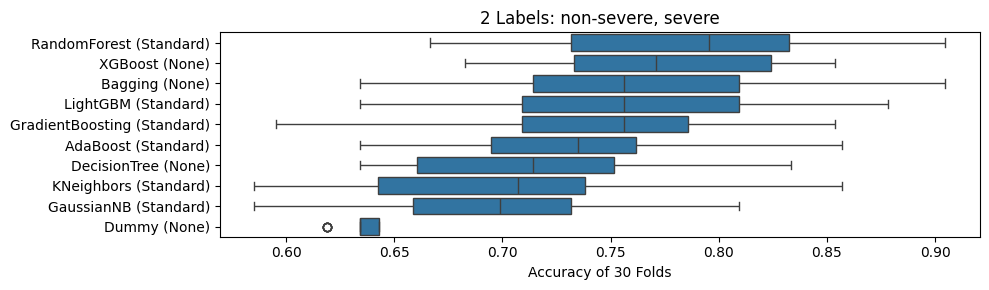

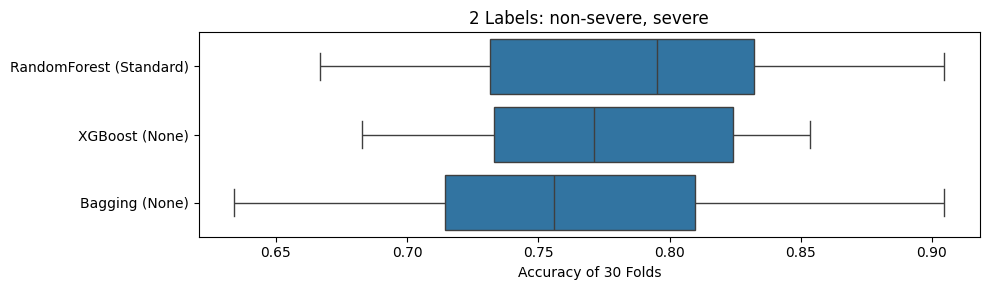

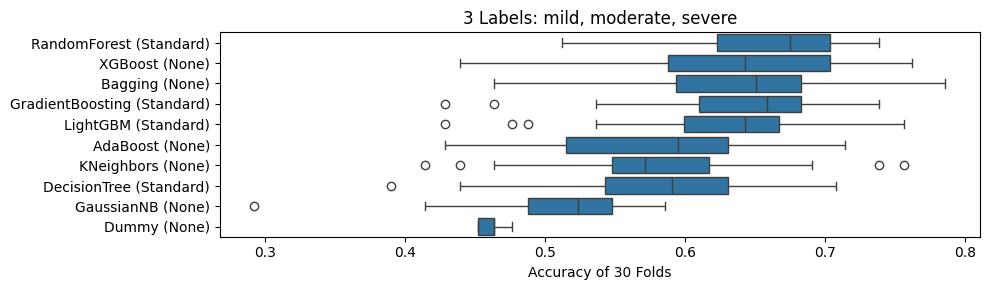

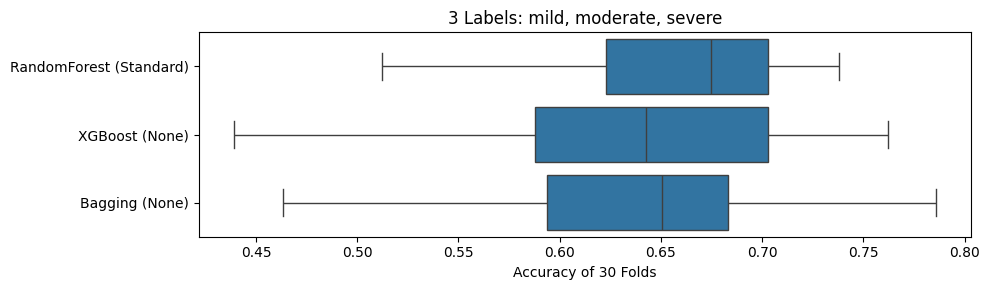

In [67]:
# Create a copy of the original results DataFrame
df_results = df_original.copy()

# Remove columns containing detailed results to simplify the analysis
df_results.drop(columns=[ALL_ROC, ALL_F1, ALL_REC, ALL_TRUE, ALL_PRED, ALL_PROB], inplace=True)

# Display the first few rows of the modified DataFrame
print("Displaying the first few rows of the modified DataFrame (detailed results removed):")
display(df_results.head())

# Format the results for better readability
# Includes rounding and applying specific formats to confidence intervals
df_rounded, df_formatted = format_results(df_results)

# Separate DataFrames for 2-label and 3-label results
df_rounded_2_labels, df_formatted_2_labels = format_results(df_results[df_results["nLabels"] == 2])
df_rounded_3_labels, df_formatted_3_labels = format_results(df_results[df_results["nLabels"] == 3])

# Display the formatted DataFrame
print("\nDisplaying the formatted DataFrame (rounded and with formatted confidence intervals):")
display(df_formatted.head())

# Process and export results for 2 labels
print("\nProcessing and displaying results for 2 labels:")
process_results(df_formatted_2_labels, n_labels=2)

# Process and export results for 3 labels
print("\nProcessing and displaying results for 3 labels:")
process_results(df_formatted_3_labels, n_labels=3)

## Export PPV and NPV


In [68]:
# Displaying PPV and NPV tables
df_results_ppv_npv_2_labels, df_results_ppv_npv_3_labels = get_ppv_npv_tables(df_original.copy())

# Sort PPV columns
ppv_columns_2 = [col for col in df_results_ppv_npv_2_labels.columns if 'PPV' in col]
ppv_columns_3 = [col for col in df_results_ppv_npv_3_labels.columns if 'PPV' in col]

# Sort the DataFrames by the first PPV column
if ppv_columns_2:
    df_results_ppv_npv_2_labels = df_results_ppv_npv_2_labels.sort_values(by=ppv_columns_2[0], ascending=False).reset_index(drop=True)
if ppv_columns_3:
    df_results_ppv_npv_3_labels = df_results_ppv_npv_3_labels.sort_values(by=ppv_columns_3[0], ascending=False).reset_index(drop=True)

# Export the PPV and NPV tables to CSV and LaTeX formats
export_single_df(df_results_ppv_npv_2_labels, "ppv_npv_values", 2)
export_single_df(df_results_ppv_npv_3_labels, "ppv_npv_values", 3)

# Display the first few rows of the PPV and NPV tables for inspection
print("Displaying PPV and NPV tables for 2 labels:")
display(df_results_ppv_npv_2_labels)
print("Displaying PPV and NPV tables for 3 labels:")
display(df_results_ppv_npv_3_labels)

Tabela salva como ../results/2_labels/tables/ppv_npv_values_2_labels.png
Tabela salva como ../results/3_labels/tables/ppv_npv_values_3_labels.png
Displaying PPV and NPV tables for 2 labels:


,Classifier,Scaler,PPV non-severe,NPV non-severe,PPV severe,NPV severe
0,RandomForest,None,0.794,0.753,0.753,0.794
1,RandomForest,Standard,0.793,0.762,0.762,0.793
2,XGBoost,None,0.791,0.729,0.729,0.791
3,XGBoost,Standard,0.790,0.727,0.727,0.790
4,Bagging,None,0.789,0.698,0.698,0.789
5,Bagging,Standard,0.787,0.690,0.690,0.787
6,LightGBM,Standard,0.782,0.703,0.703,0.782
7,GradientBoosting,Standard,0.768,0.702,0.702,0.768
8,GradientBoosting,None,0.767,0.703,0.703,0.767
9,LightGBM,None,0.767,0.691,0.691,0.767


Displaying PPV and NPV tables for 3 labels:


,Classifier,Scaler,PPV mild,NPV mild,PPV moderate,NPV moderate,PPV severe,NPV severe
0,XGBoost,None,0.662,0.771,0.439,0.856,0.656,0.803
1,XGBoost,Standard,0.659,0.767,0.451,0.857,0.651,0.801
2,RandomForest,Standard,0.652,0.794,0.590,0.851,0.669,0.816
3,RandomForest,None,0.648,0.786,0.571,0.850,0.665,0.814
4,Bagging,Standard,0.641,0.766,0.436,0.847,0.654,0.807
5,Bagging,None,0.639,0.767,0.444,0.848,0.663,0.808
6,GradientBoosting,Standard,0.636,0.789,0.385,0.843,0.678,0.798
7,LightGBM,None,0.634,0.772,0.380,0.843,0.644,0.789
8,GradientBoosting,None,0.632,0.772,0.407,0.845,0.667,0.799
9,LightGBM,Standard,0.623,0.774,0.460,0.844,0.646,0.787
